# 라이브러리

In [2]:
import tensorflow.keras as keras
import keras.layers as L
from keras import optimizers, Sequential, Model
from keras.callbacks import EarlyStopping
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler

import warnings

pd.options.display.float_format ='{:.4f}'.format
pd.set_option('display.max_column', None)
warnings.filterwarnings('ignore')

## 데이터셋 불러오기

In [170]:
dataset = pd.read_csv('./data.csv', encoding='cp949')
quality = pd.read_excel('./quality.xlsx')

## na 값 확인

In [171]:
dataset.isna().sum()

TAG_MIN                 0
배정번호                    0
건조 1존 OP                1
건조 2존 OP                1
건조로 온도 1 Zone         116
건조로 온도 2 Zone         148
세정기                    91
소입1존 OP              4288
소입2존 OP                 0
소입3존 OP                 2
소입4존 OP                 3
소입로 CP 값                1
소입로 CP 모니터 값          147
소입로 온도 1 Zone         130
소입로 온도 2 Zone         128
소입로 온도 3 Zone         157
소입로 온도 4 Zone         170
솔트 컨베이어 온도 1 Zone     106
솔트 컨베이어 온도 2 Zone     142
솔트조 온도 1 Zone         209
솔트조 온도 2 Zone         203
dtype: int64

## na 채우기, bfill로 채운 후, ffill로 첫번째 row에 있을 na도 채움

In [174]:
dataset.fillna(method='bfill', inplace=True)
dataset.fillna(method='ffill', inplace=True)

In [179]:
target_corr = dataset[list(dataset.columns[2:])].corr()

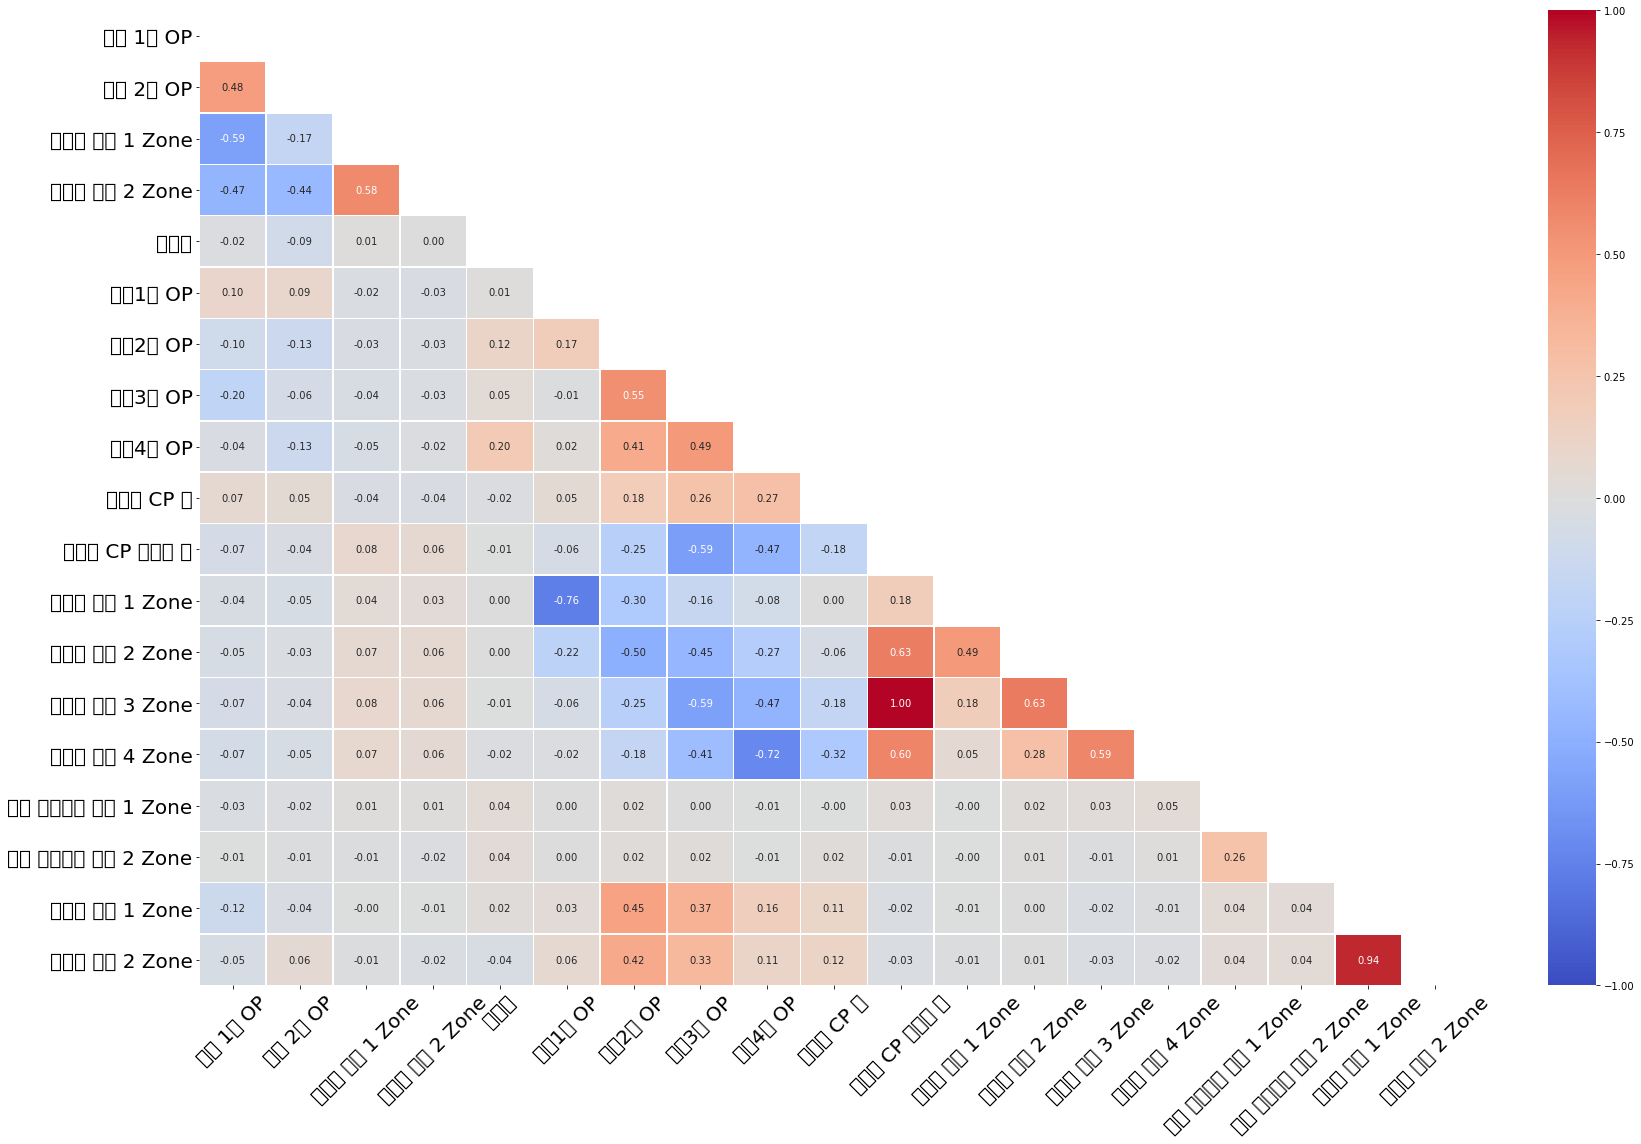

In [180]:
plt.figure(figsize=(25,16))
mask = np.triu(np.ones_like(target_corr, dtype=np.bool))
sns.heatmap(target_corr, mask=mask,
            vmin=-1, vmax=1,
            cmap ='coolwarm', linewidths=.5,
            annot=True, fmt=".2f", xticklabels=False, yticklabels=False)

plt.xticks(np.arange(0.5, len(target_corr.columns)+0.5, 1), target_corr.columns, size =20, rotation=45)
plt.yticks(np.arange(0.5, len(target_corr.index)+0.5, 1), target_corr.index, size =20)

plt.tight_layout()

In [5]:
dataset['TAG_MIN'] =pd.to_datetime(dataset.TAG_MIN, format='%Y-%m-%d %H:%M:%S')
# 상관관계 1 제거
dataset.drop(['소입로 CP 모니터 값'], axis=1, inplace=True)
# 불필요 컬럼 제거
quality.drop(columns=['작업일','공정명','설비명','양품수량'], inplace=True)

In [183]:
df_01 = dataset.copy()

## 함수 정의

In [10]:
# array 형태로 만들기
def create_dataset(X,y,time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X[i:(i + time_steps)]
        Xs.append(v)
        z = y[(i+1):(i+time_steps+1)]
        ys.append(z)
    return np.array(Xs), np.array(ys)

In [11]:
# train set을 X와 y로 나누는 과정 / 본 코드는 다음 스텝을 예측하기 위함이므로 y값도 자신이 됨
def train_test_split(train,test,TIME_STEPS):
    x_train,y_train = create_dataset(train,train,TIME_STEPS)
    x_test,y_test = create_dataset(test,test,TIME_STEPS)
    
    return x_train,x_test,y_train,y_test

In [12]:
# lstm autoencoder 모델 구축

def get_model_lstmae():
    lr = 0.0001
    encoder_decoder = Sequential()
    encoder_decoder.add(L.LSTM(x_train.shape[1], 
                               activation='relu', 
                               input_shape=(x_train.shape[1],x_train.shape[2]), 
                               return_sequences=True))
    encoder_decoder.add(L.LSTM(6, activation='relu', return_sequences=True))
    encoder_decoder.add(L.LSTM(1, activation='relu'))
    encoder_decoder.add(L.RepeatVector(n=x_train.shape[1]))
    encoder_decoder.add(L.LSTM(x_train.shape[1], activation='relu', return_sequences=True))
    encoder_decoder.add(L.LSTM(6, activation='relu', return_sequences=True))
    encoder_decoder.add(L.TimeDistributed(L.Dense(units=x_train.shape[2])))

    adam = optimizers.Adam(lr)
    encoder_decoder.compile(loss='mse', optimizer=adam)
    
    return encoder_decoder

## 초단위 데이터의 크기가 방대하여 epoch 1회에 시간이 1시간 이상 걸리므로, 이를 1분으로 압축하는 과정

In [15]:
df_01['year'] = df_01['TAG_MIN'].apply(lambda x: x.year)
df_01['month'] = df_01['TAG_MIN'].apply(lambda x: x.month)
df_01['day'] = df_01['TAG_MIN'].apply(lambda x: x.day)
df_01['hour'] = df_01['TAG_MIN'].apply(lambda x: x.hour)
df_01['minute'] = df_01['TAG_MIN'].apply(lambda x: x.minute)
df_01['second'] = df_01['TAG_MIN'].apply(lambda x: x.second)

df_02 = df_01.groupby(by=['year','month','day','hour','minute','배정번호'], as_index=False).agg(['mean'])

In [17]:
col_list = []
for i in range(len(df_02.columns)):
    col_list.append(df_02.columns[i][0])

In [18]:
df_02.columns = col_list
df_02 = df_02.reset_index()

In [20]:
df_02['ymd'] = df_02['year'].astype('str') + "-" + df_02['month'].astype('str') +"-" + df_02['day'].astype('str')
df_02['hms'] = df_02['hour'].astype('str') + ":" + df_02['minute'].astype('str') +":" + round(df_02['second']).astype('int').astype('str')
df_02['TAG_MIN'] = df_02['ymd'] + " " + df_02['hms']

df_02.drop(columns=['year','month','day','hour','minute','second','ymd','hms'], inplace=True)
df_02['TAG_MIN'] = pd.to_datetime(df_02.TAG_MIN, format='%Y-%m-%d %H:%M:%S')

### 압축 후 dtype 확인

In [23]:
df_02.dtypes

배정번호                          int64
건조 1존 OP                    float64
건조 2존 OP                    float64
건조로 온도 1 Zone               float64
건조로 온도 2 Zone               float64
세정기                         float64
소입1존 OP                     float64
소입2존 OP                     float64
소입3존 OP                     float64
소입4존 OP                     float64
소입로 CP 값                    float64
소입로 온도 1 Zone               float64
소입로 온도 2 Zone               float64
소입로 온도 3 Zone               float64
소입로 온도 4 Zone               float64
솔트 컨베이어 온도 1 Zone           float64
솔트 컨베이어 온도 2 Zone           float64
솔트조 온도 1 Zone               float64
TAG_MIN              datetime64[ns]
dtype: object

## 시계열 데이터이므로, 특정 시점에서 끊는게 아닌 배정번호별로 train test set이 분리되어야 한다고 생각하여 80% 지점에 있는 배정번호 확인하고 나누는 작업

In [24]:
aa = list(df_02.배정번호.unique())
bb = aa[:round(len(aa)*.8)]

for i in range(len(df_01)):
    if df_02['배정번호'][i] in bb:
        pass
    else:
        print(i)
        break

40650


In [25]:
df_02.iloc[40650]

배정번호                              141145
건조 1존 OP                         68.1086
건조 2존 OP                          25.845
건조로 온도 1 Zone                   100.1449
건조로 온도 2 Zone                    98.9323
세정기                              69.2354
소입1존 OP                           0.9429
소입2존 OP                          45.7734
소입3존 OP                          52.4187
소입4존 OP                          69.1665
소입로 CP 값                          0.4497
소입로 온도 1 Zone                   873.5041
소입로 온도 2 Zone                   861.6244
소입로 온도 3 Zone                   860.4288
소입로 온도 4 Zone                   860.1997
솔트 컨베이어 온도 1 Zone               285.0507
솔트 컨베이어 온도 2 Zone               284.1177
솔트조 온도 1 Zone                   331.9874
TAG_MIN              2022-06-15 17:41:36
Name: 40650, dtype: object

In [26]:
train = df_02[:40899]
test = df_02[40899:]

In [27]:
train.drop(columns=['배정번호','TAG_MIN'], inplace=True)
test.drop(columns=['배정번호','TAG_MIN'], inplace=True)

## ES 설정

In [28]:
early_stopping = EarlyStopping(patience = 10)

## scaler 및 train, test set 분리

In [30]:
train = pd.DataFrame(train, columns=df_02.columns[1:-1])
test = pd.DataFrame(test, columns=df_02.columns[1:-1])

In [32]:
TIME_STEPS = 30
# 데이터 확인용 dataframe 설정
tmp_df = pd.DataFrame(index=test[TIME_STEPS:].index)

# 각 컬럼마다 lstm을 진행
for i in range(len(train.columns)):
    print(train.columns[i])
    
    train_ = pd.DataFrame(train[train.columns[i]])
    test_ = pd.DataFrame(test[test.columns[i]])
    
    scaler = StandardScaler()
    scaler = scaler.fit(train_)
    
    train_ = scaler.transform(train_)
    test_ = scaler.transform(test_)
    
    x_train,x_test,y_train,y_test = train_test_split(train_, test_, TIME_STEPS)

    model = get_model_lstmae()

    history = model.fit(x_train,y_train, 
                        epochs =50 , # 시간 관계상 50 epoch로 설정
                        batch_size=128,
                        validation_split=0.1,
                        shuffle = False,
                        callbacks=early_stopping)

    x_train_pred = model.predict(x_train)
    
    # MSE
    train_mse_loss=np.mean(np.abs(x_train_pred,x_train),axis=1)

    x_test_pred = model.predict(x_test)

    # MAE
    test_mae_loss = np.mean(np.abs(x_test_pred - x_test), axis=1)

    # MAE의 95% 지점을 threshold로 지정
    THRESHOLD = np.percentile(test_mae_loss, 95)

    
    test_score_df = pd.DataFrame(index=test[TIME_STEPS:].index)
    test_score_df[train.columns[i]+'_loss'] = test_mae_loss
    test_score_df[train.columns[i]+'_threshold'] = THRESHOLD
    test_score_df[train.columns[i]+'_anomaly'] = test_score_df[train.columns[i]+'_loss'] > test_score_df[train.columns[i]+'_threshold']
    
    tmp_df = pd.concat([tmp_df,test_score_df],axis=1)

건조 1존 OP
Epoch 1/50
288/288 [==============================] - 38s 114ms/step - loss: 0.9547 - val_loss: 0.9521
Epoch 2/50
288/288 [==============================] - 29s 100ms/step - loss: 0.9544 - val_loss: 0.9526
Epoch 3/50
288/288 [==============================] - 32s 112ms/step - loss: 0.9538 - val_loss: 0.9531
Epoch 4/50
288/288 [==============================] - 27s 93ms/step - loss: 0.9532 - val_loss: 0.9536
Epoch 5/50
288/288 [==============================] - 29s 99ms/step - loss: 0.9525 - val_loss: 0.9541
Epoch 6/50
288/288 [==============================] - 27s 95ms/step - loss: 0.9519 - val_loss: 0.9546
Epoch 7/50
288/288 [==============================] - 28s 97ms/step - loss: 0.9513 - val_loss: 0.9550
Epoch 8/50
288/288 [==============================] - 29s 99ms/step - loss: 0.9507 - val_loss: 0.9555
Epoch 9/50
288/288 [==============================] - 22s 76ms/step - loss: 0.9502 - val_loss: 0.9559
Epoch 10/50
288/288 [==============================] - 28s 96ms/step -

In [33]:
tmp_df

,건조 1존 OP_loss,건조 1존 OP_threshold,건조 1존 OP_anomaly,건조 1존 OP_close,건조 2존 OP_loss,건조 2존 OP_threshold,건조 2존 OP_anomaly,건조 2존 OP_close,건조로 온도 1 Zone_loss,건조로 온도 1 Zone_threshold,건조로 온도 1 Zone_anomaly,건조로 온도 1 Zone_close,건조로 온도 2 Zone_loss,건조로 온도 2 Zone_threshold,건조로 온도 2 Zone_anomaly,건조로 온도 2 Zone_close,세정기_loss,세정기_threshold,세정기_anomaly,세정기_close,소입1존 OP_loss,소입1존 OP_threshold,소입1존 OP_anomaly,소입1존 OP_close,소입2존 OP_loss,소입2존 OP_threshold,소입2존 OP_anomaly,소입2존 OP_close,소입3존 OP_loss,소입3존 OP_threshold,소입3존 OP_anomaly,소입3존 OP_close,소입4존 OP_loss,소입4존 OP_threshold,소입4존 OP_anomaly,소입4존 OP_close,소입로 CP 값_loss,소입로 CP 값_threshold,소입로 CP 값_anomaly,소입로 CP 값_close,소입로 온도 1 Zone_loss,소입로 온도 1 Zone_threshold,소입로 온도 1 Zone_anomaly,소입로 온도 1 Zone_close,소입로 온도 2 Zone_loss,소입로 온도 2 Zone_threshold,소입로 온도 2 Zone_anomaly,소입로 온도 2 Zone_close,소입로 온도 3 Zone_loss,소입로 온도 3 Zone_threshold,소입로 온도 3 Zone_anomaly,소입로 온도 3 Zone_close,소입로 온도 4 Zone_loss,소입로 온도 4 Zone_threshold,소입로 온도 4 Zone_anomaly,소입로 온도 4 Zone_close,솔트 컨베이어 온도 1 Zone_loss,솔트 컨베이어 온도 1 Zone_threshold,솔트 컨베이어 온도 1 Zone_anomaly,솔트 컨베이어 온도 1 Zone_close,솔트 컨베이어 온도 2 Zone_loss,솔트 컨베이어 온도 2 Zone_threshold,솔트 컨베이어 온도 2 Zone_anomaly,솔트 컨베이어 온도 2 Zone_close,솔트조 온도 1 Zone_loss,솔트조 온도 1 Zone_threshold,솔트조 온도 1 Zone_anomaly,솔트조 온도 1 Zone_close
30,0.3299,2.7577,False,0.3427,0.5674,3.4447,False,0.3344,0.4997,1.1764,False,-0.1218,0.7810,1.3376,False,0.1761,0.1009,0.3847,False,0.7931,0.5013,1.5315,False,0.8855,0.2143,0.7769,False,0.4445,0.3424,5.3740,False,0.0097,0.4432,1.7855,False,0.1847,0.0649,0.1535,False,-0.0022,0.3110,1.3176,False,-0.2292,0.5205,1.5186,False,0.1179,0.7261,1.1254,False,-0.0016,0.3913,0.8784,False,0.2325,0.3809,0.8785,False,-1.3846,0.1463,0.5096,False,-1.2557,0.3937,0.6392,False,0.6311
31,0.3036,2.7577,False,0.4536,0.5553,3.4447,False,0.4329,0.4760,1.1764,False,-0.2360,0.6223,1.3376,False,0.0618,0.1114,0.3847,False,0.7333,0.4931,1.5315,False,0.8045,0.2077,0.7769,False,0.6326,0.3353,5.3740,False,0.2938,0.4464,1.7855,False,0.2422,0.0657,0.1535,False,0.1111,0.3054,1.3176,False,-0.1947,0.4950,1.5186,False,0.0566,0.7097,1.1254,False,-0.0193,0.3840,0.8784,False,0.2255,0.3840,0.8785,False,-1.4268,0.0867,0.5096,False,-1.3544,0.4033,0.6392,False,0.5452
32,0.3024,2.7577,False,0.3262,0.5098,3.4447,False,0.3783,0.4528,1.1764,False,-0.2018,0.4840,1.3376,False,0.0416,0.1213,0.3847,False,0.6417,0.4909,1.5315,False,0.5714,0.1713,0.7769,False,0.6486,0.2979,5.3740,False,0.2717,0.4122,1.7855,False,0.1074,0.0676,0.1535,False,0.2036,0.2734,1.3176,False,-0.0842,0.4147,1.5186,False,-0.0965,0.6726,1.1254,False,-0.1618,0.3453,0.8784,False,0.2520,0.3919,0.8785,False,-1.4274,0.0825,0.5096,False,-1.4231,0.4142,0.6392,False,0.5592
33,0.2953,2.7577,False,0.1869,0.4646,3.4447,False,0.3281,0.4141,1.1764,False,-0.0226,0.4049,1.3376,False,0.1139,0.1342,0.3847,False,0.5306,0.4859,1.5315,False,0.2926,0.1380,0.7769,False,0.6646,0.2760,5.3740,False,0.3666,0.4030,1.7855,False,0.4250,0.0690,0.1535,False,-0.0394,0.2455,1.3176,False,0.0719,0.3477,1.5186,False,-0.1409,0.6468,1.1254,False,-0.2112,0.3452,0.8784,False,0.1508,0.3894,0.8785,False,-1.3918,0.1290,0.5096,False,-1.4599,0.4221,0.6392,False,0.7247
34,0.2847,2.7577,False,0.1791,0.4264,3.4447,False,0.3623,0.3626,1.1764,False,0.0506,0.3555,1.3376,False,0.0527,0.1510,0.3847,False,0.4352,0.4817,1.5315,False,0.0889,0.1163,0.7769,False,0.7625,0.2662,5.3740,False,0.5253,0.4058,1.7855,False,0.6311,0.0717,0.1535,False,0.1343,0.2242,1.3176,False,0.2195,0.2995,1.5186,False,-0.2749,0.6386,1.1254,False,-0.4499,0.3377,0.8784,False,-0.1599,0.3716,0.8785,False,-1.3168,0.1165,0.5096,False,-1.4731,0.4312,0.6392,False,0.6590
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9264,2.0963,2.7577,False,-2.5772,3.5089,3.4447,True,-6.0318,1.3713,1.1764,True,-0.5099,1.4035,1.3376,Tru

### 데이터 저장

In [34]:
tmp_df.to_csv('./tmp_df', encoding='cp949')

### anomaly 부분만 확인

In [36]:
abnorm_list = []
for i in range(len(tmp_df.columns)):
    if '_anomaly' in tmp_df.columns[i]:
        abnorm_list.append(tmp_df.columns[i])
        
check_TF=tmp_df[abnorm_list]
check_TF['check'] = check_TF.sum(True)

### OP는 공정의 온도가 내려갔을 때 올라가는 출력이라서 제외하고 확인하기로 함

In [51]:
WO_OP =[]
for i in abnorm_list:
    if 'OP' in i:
        pass
    else:
        WO_OP.append(i)
        
check_TF_WO_OP = tmp_df[WO_OP]

In [145]:
check_TF_WO_OP.reset_index(drop=True,inplace=True)

### 어느 한 공정에서의 anomaly로 인해 불량이 나왔다고 생각하지 않았고, 연속된 공정들 속에서 연속된 구간의 anomaly가 불량품으로 이루어졌을것이라고 생각하여 연속된 공정들 중 3공정이 anomaly일 때 "T_sum_3over"의 숫자가 1 올라가게 함

### T_sum_3over : 1  --> 연속된 3개의 공정이 anomaly 
### T_sum_3over : 2  --> 연속된 4개의 공정이 anomaly or 연속된 3개의 공정 2구역이 anomaly
### T_sum_3over : 3  --> 연속된 5개의 공정이 anomaly or 연속된 3개의 공정 3구역이 anomaly / 연속된 4개의 공정이 anomaly or 연속된 3개의 공정 1구역이 anomaly / 연속된 3개의 공정이 anomaly or 연속된 3개의 공정 2구역이 anomaly

In [187]:
check_TF_WO_OP['T_sum_3over'] = 0
for j in range(len(check_TF_WO_OP)):
    k = 0
    for i in range(len(check_TF_WO_OP.iloc[j])-2):
        if sum(check_TF_WO_OP.iloc[j][i:i+3]) >= 3:
            k +=1
        else :
            pass
    check_TF_WO_OP['T_sum_3over'][j] = k

In [162]:
check_TF_WO_OP[check_TF_WO_OP['T_sum_3over']>0]

,건조로 온도 1 Zone_anomaly,건조로 온도 2 Zone_anomaly,세정기_anomaly,소입로 CP 값_anomaly,소입로 온도 1 Zone_anomaly,소입로 온도 2 Zone_anomaly,소입로 온도 3 Zone_anomaly,소입로 온도 4 Zone_anomaly,솔트 컨베이어 온도 1 Zone_anomaly,솔트 컨베이어 온도 2 Zone_anomaly,솔트조 온도 1 Zone_anomaly,T_sum_3over
481,False,False,False,False,False,True,True,True,False,False,False,1
482,False,False,False,False,False,True,True,True,False,False,False,1
483,False,False,False,False,False,True,True,True,False,False,False,1
484,False,False,False,False,True,True,True,True,False,False,False,2
485,False,False,False,False,True,True,True,True,False,False,False,2
...,...,...,...,...,...,...,...,...,...,...,...,...
6317,False,True,False,False,False,False,False,False,True,True,True,1
6318,False,True,False,False,False,False,False,False,True,True,True,1
6319,False,True,False,False,False,False,False,False,True,True,True,1
6478,True,False,False,False,False,False,False,True,True,True,False,1


### 비율 확인 및 quality의 불량률과 비교

In [169]:
print(len(check_TF_WO_OP[check_TF_WO_OP['T_sum_3over']>1])/len(check_TF_WO_OP))
print(len(check_TF_WO_OP[check_TF_WO_OP['T_sum_3over']>2])/len(check_TF_WO_OP))
print(len(check_TF_WO_OP[check_TF_WO_OP['T_sum_3over']>3])/len(check_TF_WO_OP))

0.014395497348197856
0.0007576577551683082
0.00010823682216690118


In [60]:
quality.sum(axis=0)[1]/quality.sum(axis=0)[2]

0.0003357431395151549

## "T_sum_3over"의 수가 3과 4 사이의 값이 불량률을 덮을 수 있음
## 연속된 5개의 공정이 anomaly 또는 나머지 가능성들을 확인
## 연속으로 4개의 공정이 anomaly일 때 알림을 주거나 하는 작업으로 불량률을 줄일 수 있음